# Image caption runs with various hyperparameters
## SGD optimization

### Run for <span style="color:red;">1800</span>s

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [8]:
!ls logs/fixtime/SGD/

time_limit1800s


In [9]:
logdir = "logs/fixtime/SGD/time_limit1800s"

In [10]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

8

In [11]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
validation_pattern = re.compile(r"^{'Bleu_1':\s*([0-9e\-\.]+),\s*'Bleu_2':\s*([0-9e\-\.]+),\s*'Bleu_3':\s*([0-9e\-\.]+),\s*'Bleu_4':\s*([0-9e\-\.]+),\s*'ROUGE_L':\s*([0-9e\-\.]+),\s*'CIDEr':\s*([0-9e\-\.]+)}")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0
        ind_v = 0 # DataFrame row number (index) for df_validation
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                       "epoch","time","loss"])
        df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                # Use only last line from file (with max epoch counter)
                if debug: print line,                    
                epoch = int(m2.group(1))
                time += float(m2.group(2))  # Time per epoch must be summed
                loss = float(m2.group(3))
                if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
                df_epochtime.loc[ind] = [batch,learn,run,epoch,time,loss]
                ind += 1
            else:
                m3 = validation_pattern.match(s)
                if m3:
                    if debug: print line,
                    bl1 = float(m3.group(1))
                    bl2 = float(m3.group(2))
                    bl3 = float(m3.group(3))
                    bl4 = float(m3.group(4))
                    rouge = float(m3.group(5))
                    cider = float(m3.group(6))
                    if debug: print "Bleu, Rouge, CIDEr:",bl1,bl2,bl3,bl4,rouge,cider
                    df_validation.loc[ind_v] = [batch,learn,run,
                                                bl1,bl2,bl3,bl4,
                                                rouge, cider]
                    ind_v += 1

    return (df_epochtime, df_validation)

In [12]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
    df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
    filecounter=0
    for file in files:
        if debug: print file
        df_e1,df_v1 = fileToDF(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        if len(df_v1) > 0:
            df_validation = pd.concat([df_validation,df_v1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return (df_epochtime, df_validation)

In [13]:
print logdir
df_epochtime,df_validation = readLogs(logdir)
print df_validation.shape, df_epochtime.shape

logs/fixtime/SGD/time_limit1800s
(8, 9) (818, 6)


In [14]:
df_validation[["batch","run"]] = df_validation[["batch","run"]].astype(int)
df_epochtime[["batch","run"]] = df_epochtime[["batch","run"]].astype(int)
df_validation.head()

,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,4,0.00010,0,0.134504,0.079159,0.053832,0.036271,0.157840,3.827495e-06
1,4,0.00020,0,0.135432,0.079693,0.054329,0.036765,0.158372,1.700023e-08
2,4,0.00035,0,0.135214,0.079735,0.054443,0.036868,0.158467,4.348032e-09
3,4,0.00050,0,0.135770,0.079955,0.054676,0.037030,0.158896,1.168507e-06
4,4,0.00100,0,0.136433,0.080525,0.054861,0.036987,0.159448,5.004535e-08


## Validation score

In [15]:
print df_validation.shape
df_validation.head()

(8, 9)


,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,4,0.00010,0,0.134504,0.079159,0.053832,0.036271,0.157840,3.827495e-06
1,4,0.00020,0,0.135432,0.079693,0.054329,0.036765,0.158372,1.700023e-08
2,4,0.00035,0,0.135214,0.079735,0.054443,0.036868,0.158467,4.348032e-09
3,4,0.00050,0,0.135770,0.079955,0.054676,0.037030,0.158896,1.168507e-06
4,4,0.00100,0,0.136433,0.080525,0.054861,0.036987,0.159448,5.004535e-08


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a13a450>]],
      dtype=object)

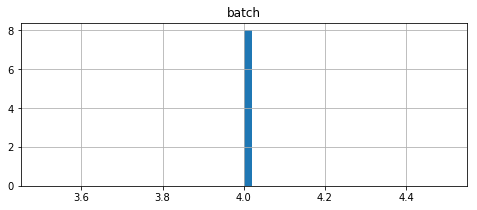

In [16]:
# Checking number of rows in the dataframe per batch size
# 7 LR values x 2 runs = 14 rows
plt.rcParams['figure.figsize'] = 8,3
df_validation[["batch"]].hist(bins=52)

In [17]:
# Take average between runs
df_mean = df_validation.groupby(["batch","lr"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,4,0.00010,0.134504,0.079159,0.053832,0.036271,0.157840,3.827495e-06
1,4,0.00020,0.135432,0.079693,0.054329,0.036765,0.158372,1.700023e-08
2,4,0.00035,0.135214,0.079735,0.054443,0.036868,0.158467,4.348032e-09
3,4,0.00050,0.135770,0.079955,0.054676,0.037030,0.158896,1.168507e-06
4,4,0.00100,0.136433,0.080525,0.054861,0.036987,0.159448,5.004535e-08


In [18]:
df_cider = df_mean.pivot_table(index="batch",columns="lr",values="cider")
df_rouge = df_mean.pivot_table(index="batch",columns="lr",values="rouge")
df_bleu1 = df_mean.pivot_table(index="batch",columns="lr",values="bleu1")
df_bleu2 = df_mean.pivot_table(index="batch",columns="lr",values="bleu2")
df_bleu3 = df_mean.pivot_table(index="batch",columns="lr",values="bleu3")
df_bleu4 = df_mean.pivot_table(index="batch",columns="lr",values="bleu4")
df_cider.head()

lr,0.0001,0.0002,0.00035,0.0005,0.001,0.0025,0.005,0.0075
batch,,,,,,,,
4,0.000004,1.700023e-08,4.348032e-09,0.000001,5.004535e-08,0.000001,2.150040e-07,4.647202e-07


In [19]:
def plotHeatMap(df,ax,title=None,cmap=None):        
    cmesh=ax.pcolormesh(df,cmap=cmap)
    fig.colorbar(mappable=cmesh,ax=ax)    
    ax.set_yticks(np.arange(0.5, len(df.index), 1))
    ax.set_yticklabels(df.index)
    ax.set_xticks(np.arange(0.5, len(df.columns), 1))
    ax.set_xticklabels(df.columns)
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                ax.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.3, 'pad':0})
    ax.set_title(title,fontsize=18)

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


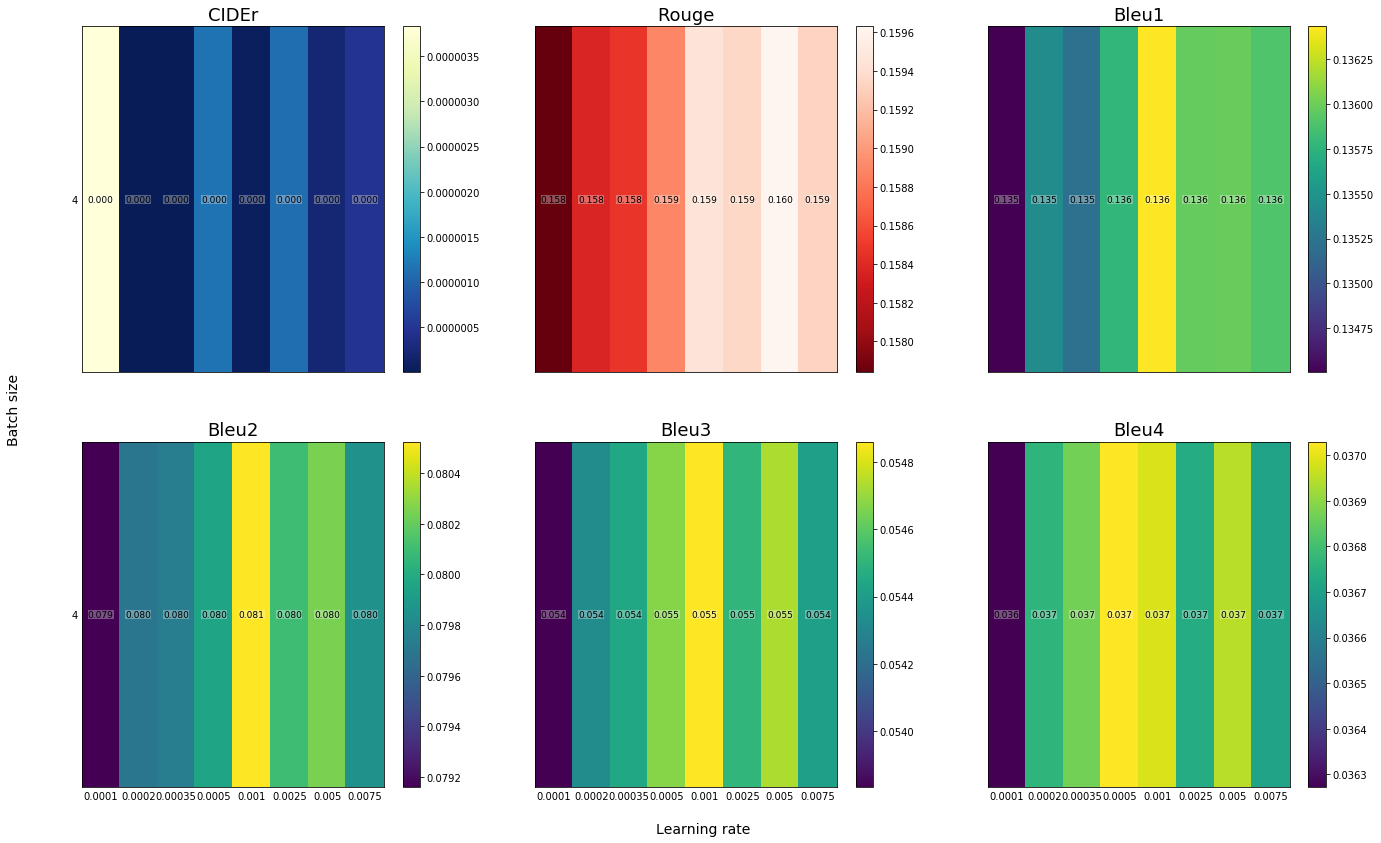

In [20]:
plt.rcParams['figure.figsize'] = 23,14
fig, ax = plt.subplots(2,3,sharex=True,sharey=True)
plotHeatMap(df_cider,ax[0,0],"CIDEr","YlGnBu_r")
plotHeatMap(df_rouge,ax[0,1],"Rouge","Reds_r")
plotHeatMap(df_bleu1,ax[0,2],"Bleu1")
plotHeatMap(df_bleu2,ax[1,0],"Bleu2")
plotHeatMap(df_bleu3,ax[1,1],"Bleu3")
plotHeatMap(df_bleu4,ax[1,2],"Bleu4")
fig.text(0.5, 0.08, 'Learning rate', ha='center',fontsize=14)
fig.text(0.08, 0.5, 'Batch size', va='center', rotation='vertical',fontsize=14)
fig.show()

## Loss and time

In [22]:
# Loss is not always at minimum at last epoch,
# so aggragation min(loss) doesn't show loss at last epoch
# though this approach also may have sence
df_maxepoch = df_epochtime.groupby(["batch","lr","run"]).agg({"epoch":"max","time":"max","loss":"min"})
df_maxepoch.head()

loss  epoch         time
batch lr      run                              
4     0.00010 0    8.956786  104.0  1804.777806
      0.00020 0    8.947234  101.0  1805.430745
      0.00035 0    8.948168  101.0  1809.883254
      0.00050 0    8.924124  103.0  1806.459138
      0.00100 0    8.950125  102.0  1812.040321

In [23]:
# Make new column with max epoch for each (batch, lr, run) combination
df_maxepoch = df_epochtime.copy()
df_maxepoch["max_epoch"] = df_epochtime.groupby(["batch","lr","run"])["epoch"].transform(np.max)
df_maxepoch = df_maxepoch.sort_values(by=["batch","lr","run"],ascending=True)
df_maxepoch.head()

,batch,lr,run,epoch,time,loss,max_epoch
0,4,0.0001,0,1.0,17.824080,8.988388,104.0
1,4,0.0001,0,2.0,35.152405,8.963908,104.0
2,4,0.0001,0,3.0,52.679152,9.001289,104.0
3,4,0.0001,0,4.0,70.053836,9.022009,104.0
4,4,0.0001,0,5.0,87.355417,9.011086,104.0


In [24]:
df_maxepoch = df_maxepoch[df_maxepoch["max_epoch"] == df_maxepoch["epoch"]]
df_maxepoch.head()

,batch,lr,run,epoch,time,loss,max_epoch
103,4,0.00010,0,104.0,1804.777806,9.023781,104.0
204,4,0.00020,0,101.0,1805.430745,9.004169,101.0
305,4,0.00035,0,101.0,1809.883254,8.948168,101.0
408,4,0.00050,0,103.0,1806.459138,8.984927,103.0
510,4,0.00100,0,102.0,1812.040321,8.985084,102.0


In [25]:
df_maxepoch[(df_maxepoch["batch"]==28) & (df_maxepoch["lr"] == 0.0025)]

,batch,lr,run,epoch,time,loss,max_epoch


In [27]:
print df_maxepoch.shape
print df_maxepoch.shape

(8, 7)
(8, 7)


In [28]:
# Take average between runs
df_mean = df_maxepoch.groupby(["batch","lr"]).mean().reset_index().drop(["run","max_epoch","time"],axis=1)
df_mean.head()

,batch,lr,epoch,loss
0,4,0.00010,104.0,9.023781
1,4,0.00020,101.0,9.004169
2,4,0.00035,101.0,8.948168
3,4,0.00050,103.0,8.984927
4,4,0.00100,102.0,8.985084


In [29]:
loss_df = df_mean[['batch','lr','loss']]
epoch_df = df_mean[['batch','lr','epoch']]

In [30]:
def getColorList(cmap,n):
    cmap = cm.get_cmap(cmap, n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i),keep_alpha=True)
        colors.append(c)
    return colors

In [31]:
def plotHeatMap(df,title=None,cmap=None):
    plt.rcParams['figure.figsize'] = 10,8
    
    if isinstance(cmap,list):
        colors_num = np.ceil(256/len(cmap))
        for org_cmap in cmap:
            colors = cm.get_cmap(org_cmap,colors_num)
            
    plt.pcolormesh(df,cmap=cmap)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    ax = plt.gca()
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                plt.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.2, 'pad':0})
    plt.title(title,fontsize=18)
    plt.xlabel("learning rate",fontsize=12)
    plt.ylabel("minibatch size",fontsize=12)
    plt.colorbar()
    plt.show()

In [32]:
loss_T = loss_df.pivot_table(index="batch",columns="lr",values="loss")
epoch_T = epoch_df.pivot_table(index="batch",columns="lr",values="epoch")

In [35]:
# Create custom colormap
colors= [u'#24368Eff',
         u'#5BBEC0ff',
         u'#F4FAC4ff']
plt.rcParams['figure.figsize'] = 5,2
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)

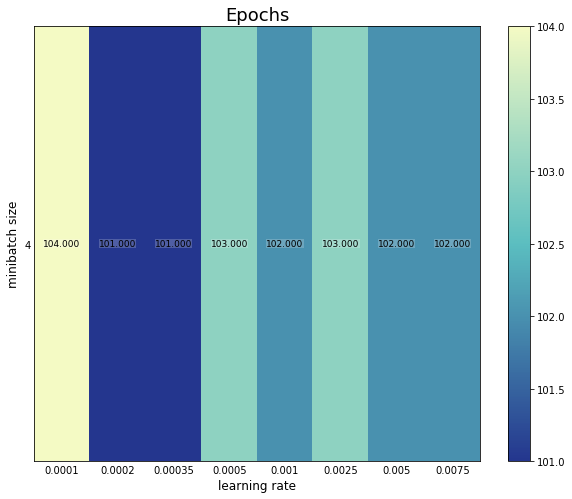

In [36]:
plotHeatMap(epoch_T,"Epochs",cmap)

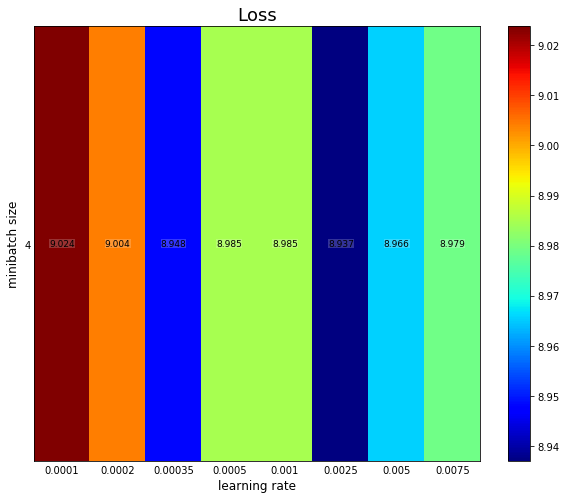

In [37]:
plotHeatMap(loss_T,"Loss","jet")

## Plot Loss graphs for each BS x LR combinations

In [42]:
# Take average between runs
df_mean_epo = df_epochtime.groupby(["batch","lr","epoch"]).mean().reset_index().drop(["run"],axis=1)
df_mean_epo[["epoch"]] = df_mean_epo[["epoch"]].astype(int)
df_mean_epo[(df_mean_epo["batch"] == 4.) & (df_mean_epo["lr"] == 0.001)].tail()

,batch,lr,epoch,time,loss
506,4,0.001,98,1739.491277,9.015155
507,4,0.001,99,1757.259363,8.966362
508,4,0.001,100,1775.216732,8.987264
509,4,0.001,101,1793.272488,8.984431
510,4,0.001,102,1812.040321,8.985084


In [43]:
df_mean_epo = df_mean_epo.sort_values(by=["batch"],ascending=False)
df_mean_epo = df_mean_epo.sort_values(by=["lr","epoch"],ascending=True)
print df_mean_epo["batch"].unique()
df_mean_epo.head(5)

[4]


,batch,lr,epoch,time,loss
0,4,0.0001,1,17.824080,8.988388
1,4,0.0001,2,35.152405,8.963908
2,4,0.0001,3,52.679152,9.001289
3,4,0.0001,4,70.053836,9.022009
4,4,0.0001,5,87.355417,9.011086


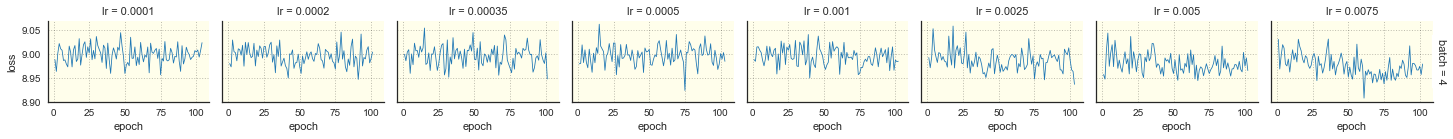

In [45]:
# Plot using Seaborn FacetGrid
# Set Seaborn global parameters
sns.set(font_scale=1)
#sns.set_style("white",{'axes.grid': True, 'grid.color': (0,0,0),'grid.linestyle':u':'})
sns.set_style("white")
#print sns.axes_style()

# Plot using "tab10" matplotlib colormap

# major_xticks = np.arange(0,176,50)
# minor_xticks = np.arange(0,176,25)
# major_yticks = np.arange(5,8.1,1)
# minor_yticks = np.arange(5,8.1,0.5)
with sns.color_palette("tab10"):
    fg = sns.FacetGrid(df_mean_epo,row="batch",col="lr",
                         row_order=df_mean_epo["batch"].unique(),
                         size=2.1,aspect=1.2,
                         #row_order=df_mean_epo.batch.unique(),
                         #xlim=(0,176),
                         #ylim=(5,8),
                         margin_titles=True,
                         subplot_kws={"facecolor":"#FFFEEB"})
    
    fg.map(plt.plot,"epoch","loss",ls="-",linewidth=.8)
    
    #print "FacetGrid:",fg.__dict__.keys()
    #print fg.axes.shape, fg.axes.size
    #axes = fg.axes.reshape(fg.axes.size)    
    for ax_arr in np.nditer(fg.axes,flags=["refs_ok"]):
        ax = ax_arr.item()
#         ax.set_xticks(major_xticks)
#         ax.set_yticks(major_yticks)
#         ax.set_xticks(minor_xticks, minor=True)        
#         ax.set_yticks(minor_yticks, minor=True)
        ax.grid(which="major",ls=":",alpha=0.25, color="black")
        ax.grid(which="minor",ls=":",alpha=0.15, color="black")

plt.show()